## Attempt to validate average streamflow cycle against observations from GRDC
* We have GRDC data already for all but 6 basins (Dniepr, Nile, Tigris & Euphrates, Indus, Ganges & Brahmaputra, Yangtze)

Basins are defined as follows: 
<font color=green>
% Key: <br>
   1.......Yukon <br>
   2.......Mackenzie<br>
   3.......Columbia<br>
   4.......Nelson<br>
   5.......Mississippi<br>
   6.......St-Lawrence<br>
   7.......Rhine<br>
   8.......Danube<br>
   9.......Dniepr<br>
   10......Volga<br>
   11......Ob<br>
   12......Yenisei<br>
   13......Lena<br>
   14......Amur<br>
   15......Orinoco<br>
   16......Parana<br>
   17......Amazonas<br>
   18......Niger<br>
   19......Congo<br>
   20......Nile<br>
   21......Zambezi<br>
   22......Tigris & Euphrates<br>
   23......Indus<br>
   24......Ganges & Brahmaputra<br>
   25......Mekong<br>
   26......Huang-he<br>
   27......Yangtze<br>
   28......Murray & Darling<br>
   29......Don<br>
   30......Fraser<br>
   31......Tocantins<br>
   32......Vuoski & Neva<br>
    </font>

In [1]:
import scipy as scipy
import scipy.stats as stats
import numpy as np
import scipy.io as sio
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
import time 
import xarray as xr
import pickle 
import os
import pandas as pd

from netCDF4 import Dataset

/home/mdfowler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mdfowler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Read in model data to re-create avg. annual cycle, as in *MeanStreamflowDistributions_V2* 

In [2]:
#Get dimensions from a single file (same will be used for all files)
file1 = '/beegfs/DATA/pritchard/mdfowler/CaMaOutput_Physiology/global_15min_physiologyFull/outflw1161.nc'
dat   = Dataset(file1)
lat   = dat.variables['lat'][:] 
lon   = dat.variables['lon'][:] 

#Read in bsin ID identifiers from Matlab file 
basinData = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/BasinMask.mat')
basinMask = basinData['BasinMask']

#Read in CaMa gridcell areas
matData = sio.loadmat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/CaMa_gridAreas.mat')
area    = matData['area']

## Read in daily data... 

#Read indices for subsetted data 
lonFile = open("/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/lonIndices_subsetKey.txt","r")
latFile = open("/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/latIndices_subsetKey.txt","r")

lonSubset=[]
for line in lonFile.readlines():
    lonSubset.append(float(line))  

latSubset=[]
for line in latFile.readlines():
    latSubset.append(float(line))

#Set filepaths for daily data
ctrlFile = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/Control_outflow_subset.nc'
fullFile = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/Full_outflow_subset.nc'
physFile = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/Physiology_outflow_subset.nc'
radFile  = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/Radiation_outflow_subset.nc'

#Read in outflow data  
fCtrl = xr.open_dataset(ctrlFile,decode_times=False)
fFull = xr.open_dataset(fullFile,decode_times=False)
fPhys = xr.open_dataset(physFile,decode_times=False)
fRad  = xr.open_dataset(radFile,decode_times=False)

outflwCtrl = fCtrl.outflow
outflwFull = fFull.outflow
outflwPhys = fPhys.outflow
outflwRad  = fRad.outflow


In [3]:
#Define list of basin names based on key (used in plotting)
basinNames = ['Yukon','Mackenzie','Columbia','Nelson','Mississippi','St-Lawrence','Rhine','Danube','Dniepr','Volga','Ob','Yenisei',\
'Lena','Amur','Orinoco','Parana','Amazonas','Niger','Congo','Nile','Zambezi','Tigris & Euphrates','Indus',\
'Ganges & Brahmaputra','Mekong','Huang-he','Yangtze','Murray & Darling','Don','Fraser','Tocantins','Vuoski & Neva']

#Define time array for plotting too
days = np.arange(365)+1

#Beginning julian days for each month
startMon = [0, 31,59, 90,120,151,181,212,243,273,304,334]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [4]:
#Define empty arrays to store basin-specific data in 
annCtrl = np.full([len(basinNames),30,365],np.nan)
annFull = np.full([len(basinNames),30,365],np.nan)
annPhys = np.full([len(basinNames),30,365],np.nan)
annRad  = np.full([len(basinNames),30,365],np.nan)
avgCtrl = np.full([len(basinNames),365],np.nan)
avgFull = np.full([len(basinNames),365],np.nan)
avgPhys = np.full([len(basinNames),365],np.nan)
avgRad = np.full([len(basinNames),365],np.nan)
avgLat = np.full([len(basinNames)],np.nan)
avgLon = np.full([len(basinNames)],np.nan)
basinArea_CaMa = np.full([len(basinNames)],np.nan)

## ---- Loop over basins ---- ##

for iBasin in range(len(basinNames)):
    basinChoice = iBasin+1
    
    #Define empty arrays and variable to count number of obs in basin
    iSubset  = []
    gridArea = []
    basinObs = 0
    
    #Loop over every location in the subset of daily data 
    for iLoc in range(len(lonSubset)): 
        ilon = int(lonSubset[iLoc])
        ilat = int(latSubset[iLoc])

        if (basinMask[ilon,ilat]==basinChoice):
            iSubset = np.append(iSubset,iLoc)               #Save iLoc (index of subset) if in basin
            gridArea = np.append(gridArea,area[ilon,ilat])  #Save area of each valid gridcell   
            basinObs = basinObs+1

    iSubset=np.asarray(iSubset,dtype=int)  
    print(basinObs, ' points used in the', basinNames[basinChoice-1])

    #Isolate just the data in specified basin for further analysis 
    basinLon  = np.take(lonSubset,iSubset)
    basinLat  = np.take(latSubset,iSubset)
    basinCtrl = np.take(outflwCtrl.values,iSubset,axis=0)
    basinFull = np.take(outflwFull.values,iSubset,axis=0)
    basinPhys = np.take(outflwPhys.values,iSubset,axis=0)
    basinRad  = np.take(outflwRad.values,iSubset,axis=0)
    avgLat[iBasin] = np.nanmean(lat[np.asarray(basinLat,dtype=int)])
    avgLon[iBasin] = np.nanmean(lon[np.asarray(basinLon,dtype=int)])
    basinArea_CaMa[iBasin] = np.nansum(gridArea*1e6) #Convert from km^2 to m^2 
    print('Basin isolated')

    #-------------------------------------------------------------------------------

    ## Create annual climatology ##

    # Area weighted averages 
    wgtAvgCtrl = np.full([30*365],np.nan)
    wgtAvgFull = np.full([30*365],np.nan)
    wgtAvgPhys = np.full([30*365],np.nan)
    wgtAvgRad  = np.full([30*365],np.nan)

    for iDay in range(30*365): 
        wgtAvgCtrl[iDay] = np.nansum(gridArea*basinCtrl[:,iDay])/np.nansum(gridArea)
        wgtAvgFull[iDay] = np.nansum(gridArea*basinFull[:,iDay])/np.nansum(gridArea)
        wgtAvgPhys[iDay] = np.nansum(gridArea*basinPhys[:,iDay])/np.nansum(gridArea)
        wgtAvgRad[iDay]  = np.nansum(gridArea*basinRad[:,iDay])/np.nansum(gridArea)
    print('Area weighting completed')

    # Split into 30 years to get at composite seasonal cycle (dimensions are [30 x 365])
    annCtrl[iBasin,:,:] = np.split(wgtAvgCtrl,30)
    annFull[iBasin,:,:] = np.split(wgtAvgFull,30)
    annPhys[iBasin,:,:] = np.split(wgtAvgPhys,30)
    annRad[iBasin,:,:]  = np.split(wgtAvgRad,30)

    # Average over years ()
    avgCtrl[iBasin,:] = np.nanmean(annCtrl[iBasin,:,:],axis=0)
    avgFull[iBasin,:] = np.nanmean(annFull[iBasin,:,:],axis=0)
    avgPhys[iBasin,:] = np.nanmean(annPhys[iBasin,:,:],axis=0) 
    avgRad[iBasin,:]  = np.nanmean(annRad[iBasin,:,:], axis=0)

    print('Annual cycle computed... Done with basin')

print('**** DONE COMPUTING BASIN STATS ****')
#Only takes about a minute to run 
    

281  points used in the Yukon
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
252  points used in the Mackenzie
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
96  points used in the Columbia
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
66  points used in the Nelson
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
264  points used in the Mississippi
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
128  points used in the St-Lawrence
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
34  points used in the Rhine
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
100  points used in the Danube
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
50  points used in the Dniepr
Basin isolated
Area weighting completed
Annual cycle computed...

In [5]:
## Estimate standard error to get at interannual variability 

stdCtrl = np.std(annCtrl,axis=1)
stdFull = np.std(annFull,axis=1)
stdPhys = np.std(annPhys,axis=1)
stdRad  = np.std(annRad,axis=1)

errCtrl = stdCtrl/np.sqrt(30)
errFull = stdFull/np.sqrt(30)
errPhys = stdPhys/np.sqrt(30)
errRad  = stdRad/np.sqrt(30)

np.shape(errCtrl)


(32, 365)

In [6]:
# Create average annual cycles at every point, don't area weight 

np.shape(outflwCtrl.values)

#Define empty arrays to store ann cycle
annAvgCtrl = np.full([len(lonSubset),365],np.nan)
annAvgFull = np.full([len(lonSubset),365],np.nan)
annAvgPhys = np.full([len(lonSubset),365],np.nan)
annAvgRad   = np.full([len(lonSubset),365],np.nan)
errCtrl     =np.full([len(lonSubset),365],np.nan)
errFull     =np.full([len(lonSubset),365],np.nan)
errPhys     =np.full([len(lonSubset),365],np.nan)
errRad      =np.full([len(lonSubset),365],np.nan)

for iloc in range(len(lonSubset)):
    ctrlTemp = np.split(outflwCtrl.values[iloc,:],30)
    fullTemp = np.split(outflwFull.values[iloc,:],30)
    physTemp = np.split(outflwPhys.values[iloc,:],30)
    radTemp  = np.split(outflwRad.values[iloc,:],30)
    
    annAvgCtrl[iloc,:] = np.nanmean(ctrlTemp,axis=0)
    annAvgFull[iloc,:] = np.nanmean(fullTemp,axis=0)
    annAvgPhys[iloc,:] = np.nanmean(physTemp,axis=0)
    annAvgRad[iloc,:]  = np.nanmean(radTemp,axis=0)
    
    errCtrl[iloc,:] = np.std(ctrlTemp,axis=0)/np.sqrt(30)
    errFull[iloc,:] = np.std(fullTemp,axis=0)/np.sqrt(30)
    errPhys[iloc,:] = np.std(physTemp,axis=0)/np.sqrt(30)
    errRad[iloc,:]  = np.std(radTemp,axis=0)/np.sqrt(30)


In [7]:
#Fill in actual global river network 

#Define empty arrays 
globalVarCtrl = np.full([len(lat),len(lon),365],np.nan)
globalVarFull = np.full([len(lat),len(lon),365],np.nan)
globalVarPhys = np.full([len(lat),len(lon),365],np.nan)
globalVarRad  = np.full([len(lat),len(lon),365],np.nan)

globalErrCtrl = np.full([len(lat),len(lon),365],np.nan)
globalErrFull = np.full([len(lat),len(lon),365],np.nan)
globalErrPhys = np.full([len(lat),len(lon),365],np.nan)
globalErrRad  = np.full([len(lat),len(lon),365],np.nan)

#Fill in river network 
for inp in range(len(lonSubset)):
    ilon = int(lonSubset[inp])
    ilat = int(latSubset[inp])
    
    globalVarCtrl[ilat,ilon,:] = annAvgCtrl[inp,:]
    globalVarFull[ilat,ilon,:] = annAvgFull[inp,:]
    globalVarPhys[ilat,ilon,:] = annAvgPhys[inp,:]
    globalVarRad[ilat,ilon,:]  = annAvgRad[inp,:]
    
    globalErrCtrl[ilat,ilon,:] = errCtrl[inp,:]
    globalErrFull[ilat,ilon,:] = errFull[inp,:]
    globalErrPhys[ilat,ilon,:] = errPhys[inp,:]
    globalErrRad[ilat,ilon,:]  = errRad[inp,:]
    

In [7]:
# #Save global annual cycle to matlab file 
# sio.savemat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/FromPython/annCycleCtrl.mat',
#            mdict={'annAvgCtrl': globalVarCtrl})

# sio.savemat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/FromPython/annCycleFull.mat',
#            mdict={'annAvgFull': globalVarFull})

# sio.savemat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/FromPython/annCyclePhys.mat',
#            mdict={'annAvgPhys': globalVarPhys})

# sio.savemat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/FromPython/annCycleRad.mat',
#            mdict={'annAvgRad': globalVarRad})

# #Takes about 2.5 mintues to run 

## For GRDC basins with multiple stations along the river, pick out the station nearest the river outlet 

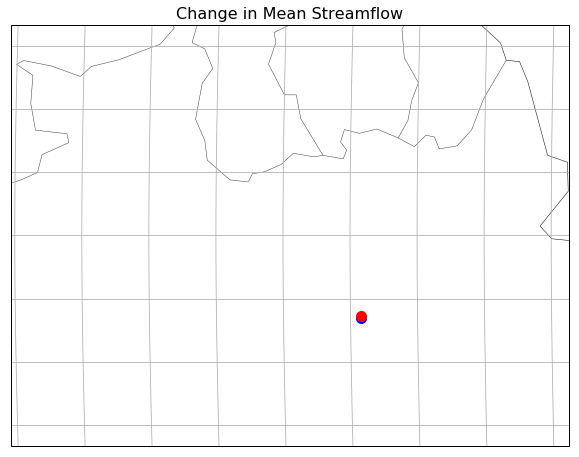

In [31]:
# fileBase = '/gdata/pritchard2/mdfowler/GRDC-data/'
# nigerIDs = [1234150,1734500]
# nigerLats = [13.520000,11.866700]
# nigerLons = [2.080000,3.383300]

# ## --- Set up figure window --- 
# fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
# fig.set_size_inches(10,10)
# ax.set_global()
# #Set up background 
# ax.set_title('Change in Mean Streamflow')
# ax.title.set_fontsize(16)
# ax.coastlines(linewidth=0.5,edgecolor='0.25')
# ax.gridlines()
# ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# #Make sure that choosing the basin with the largest catchment area is closest to outlet
# plt.plot(nigerLons[0],nigerLats[0],color='Blue',linestyle='none',marker='o',markersize=2,transform=ccrs.PlateCarree())
# plt.plot(nigerLons[1],nigerLats[1],color='Red',linestyle='none',marker='o',markersize=2,transform=ccrs.PlateCarree())
# #Plot Mekong basin with largest catchment area 
# plt.plot(105.945000,13.533000,color='Purple',linestyle='none',marker='o',markersize=2,transform=ccrs.PlateCarree())
# #Plot the two Yenisey points 
# plt.plot(86.500000,67.480000,color='Blue',linestyle='none',marker='o',markersize=2,transform=ccrs.PlateCarree())
# plt.plot(90.080000,61.600000,color='Red',linestyle='none',marker='o',markersize=2,transform=ccrs.PlateCarree())
# #Plot the two Amazonas points 
# plt.plot(-55.511100,-1.947200,color='Blue',linestyle='none',marker='o',markersize=10,transform=ccrs.PlateCarree())
# plt.plot(-55.513100,-1.919200,color='Red',linestyle='none',marker='o',markersize=10,transform=ccrs.PlateCarree())
# ax.set_extent([-65,-50,-5,5], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Amazonas River 



In [ ]:
#Pretty inefficient. Just choose the one with the largest catchment area 

## For each river basin, create annual average streamflow cycle from GRDC obs

In [8]:
#Match basins from basin key (CaMa data) to GRDC discharge filenames 
grdcID = np.full([len(basinNames)],np.nan)

#Fill empty array with GRDC ID strings for filenames 
grdcID[19-1] = '1147010'
grdcID[18-1] = '1734500'
grdcID[21-1] = '1891500'
grdcID[26-1] = '2180711'

grdcID[25-1] = '2569005'  # Mekong
#grdcID[25-1] = '2969010'

grdcID[13-1] = '2903430'  #Lena
grdcID[14-1] = '2906900'
grdcID[12-1] = '2909150'
grdcID[11-1] = '2912600'
grdcID[15-1] = '3206720'
grdcID[16-1] = '3265601'
grdcID[17-1] = '3629000'
grdcID[31-1] = '3649950'
grdcID[1-1]  = '4103200'
grdcID[3-1]  = '4115201'
grdcID[5-1]  = '4127800'  #Mississippi
grdcID[30-1] = '4207900'
grdcID[2-1]  = '4208150'
grdcID[4-1]  = '4213720'
grdcID[6-1]  = '4243150'
grdcID[28-1] = '5204251'
grdcID[7-1]  = '6435060'
grdcID[8-1]  = '6742900'
grdcID[32-1] = '6972430'
grdcID[10-1] = '6977100'
grdcID[29-1] = '6978250'

#Check that all basins entered - output should be 6
print(np.sum(np.isnan(grdcID)))

6


In [9]:
baseFilepath = '/gdata/pritchard2/mdfowler/GRDC-data/'

#Read in data for each basin to determine maximum number of days included 
lenData = np.full([len(grdcID)],np.nan)
lonGRDC = np.full([len(grdcID)],np.nan)
latGRDC = np.full([len(grdcID)],np.nan)

for iFile in range(len(grdcID)):
    if np.isnan(grdcID[iFile])==False:
        fileName = baseFilepath+np.array2string(grdcID[iFile])+'day'
    
        data = pd.read_csv(fileName, sep=";", header=40,names=['Date','HH:MM','Original','Calculated','Flag'])
        data['Date'] = data['Date'].str.split('-')
        
        lenData[iFile] = len(data)
    
        #Get lat and lon of GRDC station (only way I know how to do this right now) 
        with open(fileName,"r", encoding="latin-1") as fi:
            for ln in fi:
                if ln.startswith("# Latitude (dec. °)"):
                    latGRDC[iFile]=ln[25:]
                if ln.startswith("# Longitude (de. °)"):
                    lonGRDC[iFile]=ln[25:]

print('Max number of days in a file: ', np.nanmax(lenData))

#Read in data for each basin and save in large arrays 
year  = np.full([len(grdcID),int(np.nanmax(lenData))],np.nan)  #Define empty arrays 
month = np.full([len(grdcID),int(np.nanmax(lenData))],np.nan)
day   = np.full([len(grdcID),int(np.nanmax(lenData))],np.nan)
orig  = np.full([len(grdcID),int(np.nanmax(lenData))],np.nan)
calc  = np.full([len(grdcID),int(np.nanmax(lenData))],np.nan)
flag  = np.full([len(grdcID),int(np.nanmax(lenData))],np.nan)

for iFile in range(len(grdcID)):
    if np.isnan(grdcID[iFile])==False:
        fileName = baseFilepath+np.array2string(grdcID[iFile])+'day'

        #Read in GRDC data using pandas 
        data = pd.read_csv(fileName, sep=";", header=40,names=['Date','HH:MM','Original','Calculated','Flag'])
        data['Date'] = data['Date'].str.split('-')

        #Save data from df into numpy array (more familiar to me now)
        for it in range(len(data['Date'])):
            year[iFile,it]  = np.asarray(data['Date'][it][0],dtype=int)
            month[iFile,it] = np.asarray(data['Date'][it][1],dtype=int)
            day[iFile,it]   = np.asarray(data['Date'][it][2],dtype=int)

        orig[iFile,0:len(data)] = data.Original.values
        calc[iFile,0:len(data)] = data.Calculated.values
        flag[iFile,0:len(data)] = data.Flag.values
        
    print('Done with basin...', iFile)
    

Max number of days in a file:  41273.0
Done with basin... 0
Done with basin... 1
Done with basin... 2
Done with basin... 3
Done with basin... 4
Done with basin... 5
Done with basin... 6
Done with basin... 7
Done with basin... 8
Done with basin... 9
Done with basin... 10
Done with basin... 11
Done with basin... 12
Done with basin... 13
Done with basin... 14
Done with basin... 15
Done with basin... 16
Done with basin... 17
Done with basin... 18
Done with basin... 19
Done with basin... 20
Done with basin... 21
Done with basin... 22
Done with basin... 23
Done with basin... 24
Done with basin... 25
Done with basin... 26
Done with basin... 27
Done with basin... 28
Done with basin... 29
Done with basin... 30
Done with basin... 31


In [10]:
# #Save GRDC lon and lat out to matlab file as well 

# sio.savemat('/gdata/pritchard2/mdfowler/Flooding-physiology/MatlabData/FromPython/GRDCstationLocations.mat',
#            mdict={'lonGRDC': lonGRDC, 'latGRDC': latGRDC})



In [10]:
## ---- Manual identification of nearest and outlet gridcells ---- ## 
nearestLon = np.full([len(grdcID)],np.nan)
nearestLat = np.full([len(grdcID)],np.nan)
outletLon  = np.full([len(grdcID)],np.nan)
outletLat  = np.full([len(grdcID)],np.nan)

#Yukon (basinId = 1) [GRDC: -162.8829,61.9337]
ilon = np.where((lon>-164)&(lon<-162))
ilat = np.where((lat>61)&(lat<63))
nearestLon[0] = lon[ilon[0][5]]
nearestLat[0] = lat[ilat[0][3]]
#print(globalVarCtrl[ilat[0][3],ilon[0][5],0])
#--[CaMa: -162.625,62.125]


#Mackenzie (basinId = 2) [GRDC: -126.8442, 65.2739]
ilon = np.where((lon>-127)&(lon<-126))
ilat = np.where((lat>64.5)&(lat<65.5))
nearestLon[1] = lon[ilon[0][0]]
nearestLat[1] = lat[ilat[0][1]]
#print(globalVarCtrl[ilat[0][1],ilon[0][0],0])
#print(nearestLon[1],nearestLat[1])
#--[CaMa: -126.875,65.125]


#Columbia (basinId=3) [GRDC: -123.1840, 46.1815]
ilon = np.where((lon>-123.5) & (lon<-122.5))
ilat = np.where((lat>45.5) & (lat<46.5))
nearestLon[2] = lon[ilon[0][1]]
nearestLat[2] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][1],0])
# print(nearestLon[2],nearestLat[2])
#--[CaMa: -123.125,46.125]


#Nelson (basinId=4) [GRDC:  -96.5250, 56.0389]
ilon = np.where((lon>-97) & (lon<-96))
ilat = np.where((lat>55.5) & (lat<56.5))
nearestLon[3] = lon[ilon[0][1]]
nearestLat[3] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][1],0])
# print(nearestLon[3],nearestLat[3])
#--[CaMa: -96.625,55.875]


#Mississippi (basinId=5) [GRDC:  -90.9058, 32.3150]
ilon = np.where((lon>-91.5) & (lon<-90.5))
ilat = np.where((lat>32) & (lat<33))
nearestLon[4] = lon[ilon[0][2]]
nearestLat[4] = lat[ilat[0][3]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][3],ilon[0][2],0])
# print(nearestLon[4],nearestLat[4])
#--[CaMa: -90.875,32.125]


#St. Lawrence (basinId=6) [GRDC:  -74.7953, 45.0058]
ilon = np.where((lon>-75) & (lon<-74))
ilat = np.where((lat>44.5) & (lat<45.5))
nearestLon[5] = lon[ilon[0][0]]
nearestLat[5] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][0],0])
# print(nearestLon[5],nearestLat[5])
#--[CaMa: -74.875,44.875]


#Rhine (basinId=7) [GRDC:  6.1100, 51.8400]
ilon = np.where((lon>5.5) & (lon<6.5))
ilat = np.where((lat>51.5) & (lat<52.5))
nearestLon[6] = lon[ilon[0][2]]
nearestLat[6] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[6],nearestLat[6])
#--[CaMa: 6.125, 51.875]


#Danube (basinId=8) [GRDC: 28.7167, 45.2167]
ilon = np.where((lon>28) & (lon<29))
ilat = np.where((lat>44.5) & (lat<45.5))
nearestLon[7] = lon[ilon[0][2]]
nearestLat[7] = lat[ilat[0][0]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][0],ilon[0][2],0])
# print(nearestLon[7],nearestLat[7])
#--[CaMa: 28.625 45.375]


#Dniepr (basinId=9) [GRDC: -----]
# No GRDC data


#Volga (basinId=10) [GRDC: 44.5858, 48.8047]
ilon = np.where((lon>44) & (lon<45))
ilat = np.where((lat>48.5) & (lat<49.5))
nearestLon[9] = lon[ilon[0][2]]
nearestLat[9] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[9],nearestLat[9])
#--[CaMa: 44.625,48.875] 


#Ob (basinId=11) [GRDC: 66.5300, 66.5700]
ilon = np.where((lon>66) & (lon<67))
ilat = np.where((lat>66) & (lat<67))
nearestLon[10] = lon[ilon[0][1]]
nearestLat[10] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][1],0])
# print(nearestLon[10],nearestLat[10])
#--[CaMa: 66.375,66.625] 


#Yenisei (basinId=12) [GRDC: 86.5000, 67.4800]
ilon = np.where((lon>86) & (lon<87))
ilat = np.where((lat>67) & (lat<68))
nearestLon[11] = lon[ilon[0][1]]
nearestLat[11] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][1],0])
# print(nearestLon[11],nearestLat[11])
#--[CaMa: 86.375, 67.375] 


#Lena (basinId=13) [GRDC: 126.8000, 72.3700]
ilon = np.where((lon>126.5) & (lon<127.5))
ilat = np.where((lat>72) & (lat<73))
nearestLon[12] = lon[ilon[0][1]]
nearestLat[12] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][1],0])
# print(nearestLon[12],nearestLat[12])
#--[CaMa: 126.875, 72.375] 


#Amur (basinId=14) [GRDC: 137.1200, 50.6300]
ilon = np.where((lon>136.5) & (lon<137.5))
ilat = np.where((lat>50) & (lat<51))
nearestLon[13] = lon[ilon[0][2]]
nearestLat[13] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][2],0])
# print(nearestLon[13],nearestLat[13])
#--[CaMa: 137.125, 50.625] 


#Orinoco (basinId=15) [GRDC: -63.6000, 8.1500]
ilon = np.where((lon>-64) & (lon<-63))
ilat = np.where((lat>7.5) & (lat<8.5))
nearestLon[14] = lon[ilon[0][1]]
nearestLat[14] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][1],0])
# print(nearestLon[14],nearestLat[14])
#--[CaMa: -63.625, 8.125] 


#Parana (basinId=16) [GRDC: -60.7100, -32.6700]
ilon = np.where((lon>-61) & (lon<-60))
ilat = np.where((lat>-33) & (lat<-32))
nearestLon[15] = lon[ilon[0][1]]
nearestLat[15] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][1],0])
# print(nearestLon[15],nearestLat[15])
#--[CaMa: -60.625, -32.625] 


#Amazonas (basinId=17) [GRDC: -55.5111, -1.9472]
ilon = np.where((lon>-56) & (lon<-55))
ilat = np.where((lat>-2.5) & (lat<-1.5))
nearestLon[16] = lon[ilon[0][2]]
nearestLat[16] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][2],0])
# print(nearestLon[16],nearestLat[16])
#--[CaMa: -55.375, -1.875] 


#Niger (basinId=18) [GRDC: 3.3833, 11.8667]
ilon = np.where((lon>3) & (lon<4))
ilat = np.where((lat>11.5) & (lat<12.5))
nearestLon[17] = lon[ilon[0][1]]
nearestLat[17] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][1],0])
# print(nearestLon[17],nearestLat[17])
#--[CaMa: 3.375, 11.875] 


#Congo (basinId=19) [GRDC: 15.3000, -4.3000]
ilon = np.where((lon>15) & (lon<16))
ilat = np.where((lat>-5) & (lat<-4))
nearestLon[18] = lon[ilon[0][1]]
nearestLat[18] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][1],0])
# print(nearestLon[18],nearestLat[18])
#--[CaMa: 15.375, -4.375] 


#Nile (basinId=20) [GRDC: -----]
# No GRDC data 


#Zambezi (basinId=21) [GRDC: 33.5917, -16.1500]
ilon = np.where((lon>33) & (lon<34))
ilat = np.where((lat>-16.5) & (lat<-15.5))
nearestLon[20] = lon[ilon[0][2]]
nearestLat[20] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[20],nearestLat[20])
#--[CaMa: 33.625, -16.125] 


#Tigris & Euph. (basinId=22) [GRDC: -----]
# No GRDC data


#Indus (basinId=23) [GRDC: -----]
# No GRDC data 


#Ganges & Bhr. (basinId=24) [GRDC: -----]
# No GRDC data


# #Mekong (basinId=25) [GRDC: 105.9450, 13.5330] --- Nearest mouth of river 
ilon = np.where((lon>105.5) & (lon<106.5))
ilat = np.where((lat>13) & (lat<14))
nearestLon[24] = lon[ilon[0][1]]
nearestLat[24] = lat[ilat[0][1]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][1],ilon[0][1],0])
# print(nearestLon[24],nearestLat[24])
#--[CaMa: 105.875, 13.625] 


#Huang-He (basinId=26) [GRDC: 106.6667, 39.1333]
ilon = np.where((lon>106) & (lon<107))
ilat = np.where((lat>38.5) & (lat<39.5))
nearestLon[25] = lon[ilon[0][2]]
nearestLat[25] = lat[ilat[0][0]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][0],ilon[0][2],0])
# print(nearestLon[25],nearestLat[25])
#--[CaMa: 106.625, 39.375] 


#Yangtze (basinId=27) [GRDC: -----]
# No GRDC station 


#Murray & Darling (basinId=28) [GRDC: 142.2687, -33.7433]
ilon = np.where((lon>141.5) & (lon<142.5))
ilat = np.where((lat>-34) & (lat<-33))
nearestLon[27] = lon[ilon[0][2]]
nearestLat[27] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[27],nearestLat[27])
#--[CaMa: 142.375, -33.625] 


#Don(basinId=29) [GRDC: 40.6472, 47.5408]
ilon = np.where((lon>40) & (lon<41))
ilat = np.where((lat>47) & (lat<48))
nearestLon[28] = lon[ilon[0][2]]
nearestLat[28] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[28],nearestLat[28])
#--[CaMa: 40.625, 47.375] 


#Don(basinId=30) [GRDC: -121.4514, 49.3806]
ilon = np.where((lon>-122) & (lon<-121))
ilat = np.where((lat>49) & (lat<50))
nearestLon[29] = lon[ilon[0][2]]
nearestLat[29] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[29],nearestLat[29])
#--[CaMa: -121.375, 49.375] 


#Tocantins(basinId=31) [GRDC: -49.6533, -3.7578]
ilon = np.where((lon>-50) & (lon<-49))
ilat = np.where((lat>-4) & (lat<-3))
nearestLon[30] = lon[ilon[0][1]]
nearestLat[30] = lat[ilat[0][3]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][3],ilon[0][1],0])
# print(nearestLon[30],nearestLat[30])
#--[CaMa: -49.625, -3.875] 


#Tocantins(basinId=32) [GRDC: 30.5294, 59.8372]
ilon = np.where((lon>30) & (lon<31))
ilat = np.where((lat>59.5) & (lat<60.5))
nearestLon[31] = lon[ilon[0][2]]
nearestLat[31] = lat[ilat[0][2]]
# print(lon[ilon])
# print(lat[ilat])
# print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# print(nearestLon[31],nearestLat[31])
#--[CaMa: 30.625, 59.875] 


In [193]:
# #Interpolate CaMa data to these station locations 


# for iStation in range(len(lonGRDC)):
#     lonPoint = lonGRDC[iStation]
#     latPoint = latGRDC[iStation]

# np.shape(globalVarCtrl)

# X,Y = np.meshgrid(lon,lat)
# Xi,Yi = np.meshgrid(lonPoint,latPoint)
# testData = globalVarCtrl[:,:,0]

# f = interpolate.griddata((X.flatten(),Y.flatten()),testData.flatten(),(Xi,Yi),method='nearest')


# #f = interpolate.interp2d(x, y, z, kind='cubic')
# #znew = f(xnew, ynew)


In [12]:
np.shape(year)

print('Min years: ',np.nanmin(year,axis=1))
print('Max years: ',np.nanmax(year,axis=1))
print('Largest min year: ', np.nanmax(np.nanmin(year,axis=1)))
print('Smallest max year: ', np.nanmin(np.nanmax(year,axis=1)))

Min years:  [1975. 1943. 1968. 1960. 1931. 1958. 1901. 1931.   nan 1962. 1954. 1955.
 1951. 1940. 1923. 1905. 1927. 1952. 1903.   nan 1960.   nan   nan   nan
 1960. 1978.   nan 1941. 1952. 1912. 1978. 1945.]
Max years:  [2015. 2013. 2015. 2011. 2014. 1993. 2013. 2010.   nan 2010. 2010. 2011.
 2002. 2006. 1989. 2014. 1998. 2000. 2010.   nan 1990.   nan   nan   nan
 1993. 1997.   nan 2008. 2010. 2012. 2010. 2011.]
Largest min year:  1978.0
Smallest max year:  1989.0


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  


<font color=purple>
    Now that all the data is read in from GRDC... <br>
    Let's define a thirty year period, ending with the last year of available data in each basin. <br>
</font>

In [11]:
#Remove missing data and replace with NaN 
orig[np.where(orig==-999)]=np.nan
orig[np.where(orig==999)]=np.nan

calc[np.where(calc==-999)]=np.nan
calc[np.where(calc==999)]=np.nan


In [12]:
np.shape(calc)

(32, 41273)

In [12]:
#Set range of years to consider 
maxYr = 2005
minYr = 1970

daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

origAnnAvg = np.full([len(grdcID),365],np.nan)
calcAnnAvg = np.full([len(grdcID),365],np.nan)
errOrig    = np.full([len(grdcID),365],np.nan)
errCalc    = np.full([len(grdcID),365],np.nan)

for iBasin in range(len(grdcID)): 
    if np.isnan(grdcID[iBasin])==False:
        
        #Find indices of first/last day to consider 
        iStart = np.nanmin(np.where(year[iBasin,:]>=minYr))
        iEnd   = np.nanmax(np.where(year[iBasin,:]<=maxYr))
        
        #Limit arrays to valid years 
        yrSel   = year[iBasin,iStart:iEnd]
        monSel  = month[iBasin,iStart:iEnd]
        daySel  = day[iBasin,iStart:iEnd]
        origSel = orig[iBasin,iStart:iEnd]
        calcSel = calc[iBasin,iStart:iEnd]
        
        #Define julian day counter for indexing 
        dayCount = 0 
        
        #Loop over months and days 
        for iMon in range(12):
            for iDay in range(daysPerMonth[iMon]):
                #Find all dates of a certain month-day in the selected years 
                valDays = np.where((monSel==iMon+1) & (daySel==iDay+1))
                
                #Define average flow on this day 
                origAnnAvg[iBasin,dayCount] = np.nanmean(origSel[valDays])
                calcAnnAvg[iBasin,dayCount] = np.nanmean(calcSel[valDays])
                
                #Define standard error 
                errOrig[iBasin,dayCount] = np.nanstd(origSel[valDays])/np.sqrt(len(origSel[valDays]))                
                errCalc[iBasin,dayCount] = np.nanstd(calcSel[valDays])/np.sqrt(len(calcSel[valDays]))
                
                dayCount=dayCount+1
        
    print('Done with basin ', iBasin)


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


Done with basin  0
Done with basin  1
Done with basin  2
Done with basin  3
Done with basin  4
Done with basin  5
Done with basin  6
Done with basin  7
Done with basin  8
Done with basin  9
Done with basin  10
Done with basin  11
Done with basin  12
Done with basin  13
Done with basin  14
Done with basin  15
Done with basin  16
Done with basin  17
Done with basin  18
Done with basin  19
Done with basin  20
Done with basin  21
Done with basin  22
Done with basin  23
Done with basin  24
Done with basin  25
Done with basin  26
Done with basin  27
Done with basin  28
Done with basin  29
Done with basin  30
Done with basin  31


## Plotting

*Make plot for GRDC station vs. entire basin average streamflow cycle*

24


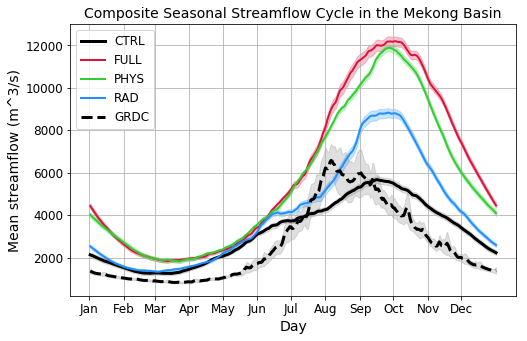

In [35]:
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14

#for iBasin in range(len(grdcID)): 

iBasin=24

print(iBasin)
## --- Set axes and size sections --- 
plt.plot(days,avgCtrl[iBasin,:],color ='Black',label='CTRL',linewidth=3)
plt.plot(days,avgFull[iBasin,:],color ='Crimson',label='FULL',linewidth=2)
plt.plot(days,avgPhys[iBasin,:],color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(days,avgRad[iBasin,:],color='DodgerBlue',label='RAD',linewidth=2)
plt.plot(days,calcAnnAvg[iBasin,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)

#Add error "bars"
plt.fill_between(days,avgCtrl[iBasin,:]-(2*errCtrl[iBasin,:]),avgCtrl[iBasin,:]+(2*errCtrl[iBasin,:]),alpha=0.25,color='Grey')
plt.fill_between(days,avgFull[iBasin,:]-(2*errFull[iBasin,:]),avgFull[iBasin,:]+(2*errFull[iBasin,:]),alpha=0.25,color='Crimson')
plt.fill_between(days,avgPhys[iBasin,:]-(2*errPhys[iBasin,:]),avgPhys[iBasin,:]+(2*errPhys[iBasin,:]),alpha=0.25,color='LimeGreen')
plt.fill_between(days,avgRad[iBasin,:]-(2*errRad[iBasin,:]),avgRad[iBasin,:]+(2*errRad[iBasin,:]),alpha=0.25,color='DodgerBlue')
plt.fill_between(days,calcAnnAvg[iBasin,:]-(2*errCalc[iBasin,:]),calcAnnAvg[iBasin,:]+(2*errCalc[iBasin,:]),alpha=0.25,color='Grey')


plt.legend(fontsize=12)
plt.title('Composite Seasonal Streamflow Cycle in the '+basinNames[iBasin]+ ' Basin',fontsize=my_fontsize)
plt.xlabel('Day',fontsize=my_fontsize)
plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
plt.grid()
plt.xticks(startMon,months)
plt.tick_params(axis='both',labelsize=12)

#Save the image 
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/BasinStreamflow/withGRDC_FullBasin/'+basinNames[iBasin]+'Upstream_SeasonalCycle.jpg'
fig.savefig(fileName)  #HOW TO SAVE FIGURES 

#plt.close()



*Make plot for single GRDC station near outlet of river and single nearby CaMa gridcell seasonal cycle*

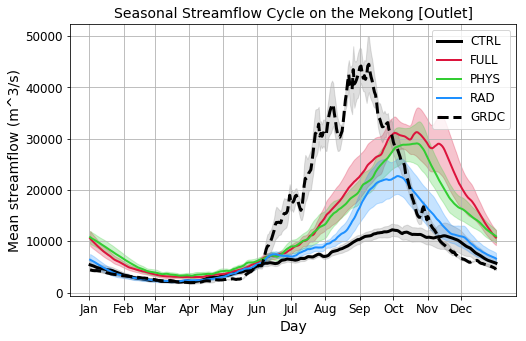

In [13]:
# --- Try making river discharge vs. GRDC at nearby gridcell 
iB = 24

indlon = np.where(lon==nearestLon[iB])
indlat = np.where(lat==nearestLat[iB])

fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and size sections --- 
plt.plot(days,np.squeeze(globalVarCtrl[indlat,indlon,:]),color ='Black',label='CTRL',linewidth=3)
plt.plot(days,np.squeeze(globalVarFull[indlat,indlon,:]),color ='Crimson',label='FULL',linewidth=2)
plt.plot(days,np.squeeze(globalVarPhys[indlat,indlon,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(days,np.squeeze(globalVarRad[indlat,indlon,:]),color='DodgerBlue',label='RAD',linewidth=2)
plt.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
plt.fill_between(days,np.squeeze(globalVarCtrl[indlat,indlon,:])-(2*np.squeeze(globalErrCtrl[indlat,indlon,:])),np.squeeze(globalVarCtrl[indlat,indlon,:])+(2*np.squeeze(globalErrCtrl[indlat,indlon,:])),alpha=0.25,color='Grey')
plt.fill_between(days,np.squeeze(globalVarFull[indlat,indlon,:])-(2*np.squeeze(globalErrFull[indlat,indlon,:])),np.squeeze(globalVarFull[indlat,indlon,:])+(2*np.squeeze(globalErrFull[indlat,indlon,:])),alpha=0.25,color='Crimson')
plt.fill_between(days,np.squeeze(globalVarPhys[indlat,indlon,:])-(2*np.squeeze(globalErrPhys[indlat,indlon,:])),np.squeeze(globalVarPhys[indlat,indlon,:])+(2*np.squeeze(globalErrPhys[indlat,indlon,:])),alpha=0.25,color='LimeGreen')
plt.fill_between(days,np.squeeze(globalVarRad[indlat,indlon,:])-(2*np.squeeze(globalErrRad[indlat,indlon,:])),np.squeeze(globalVarRad[indlat,indlon,:])+(2*np.squeeze(globalErrRad[indlat,indlon,:])),alpha=0.25,color='DodgerBlue')
plt.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')

plt.legend(fontsize=12)
plt.title('Seasonal Streamflow Cycle on the '+basinNames[iB]+ ' [Outlet]',fontsize=my_fontsize)
plt.xlabel('Day',fontsize=my_fontsize)
plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
plt.grid()
plt.xticks(startMon,months)
plt.tick_params(axis='both',labelsize=12)

#Save the image 
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/BasinStreamflow/withGRDC_singleGridcell/'+basinNames[iB]+'SeasonalCycle.jpg'
fig.savefig(fileName)  #HOW TO SAVE FIGURES 


## Can we look at stations more upstream?

In [13]:
mekongIDs  = [2469050, 2469072, 2469260, 2569005, 2969010,2969090, 2969095, 
              2969100, 2969101, 2969430]
nigerIDs   = [1234150, 1734500]
zambeziIDs = [1291100, 1891500]
lenaIDs    = [2903420, 2903430]
yeniseiIDs = [2909150, 2909152]
obIDs      = [2912600, 2912602]
tocantinsIDs   = [3649900,3649950]
yukonIDs       = [4103200, 4103550]
columbiaIDs    = [4115200, 4115201]
mississippiIDs = [4127501, 4127800]
mackzenzieIDs  = [4208005, 4208150]
rhineIDs       = [6335020, 6435060]
danubeIDs      = [6742800, 6742900]



In [62]:
baseFilepath = '/gdata/pritchard2/mdfowler/GRDC-data/'

chooseBasin = mississippiIDs

#Set range of years to consider 
maxYr = 2005
minYr = 1970
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

lonGRDC_allBasin    = np.full([len(chooseBasin)],np.nan)
latGRDC_allBasin    = np.full([len(chooseBasin)],np.nan)

origAnnAvg_allBasin = np.full([len(chooseBasin),365],np.nan)
calcAnnAvg_allBasin = np.full([len(chooseBasin),365],np.nan)
errOrig_allBasin    = np.full([len(chooseBasin),365],np.nan)
errCalc_allBasin    = np.full([len(chooseBasin),365],np.nan)


for iFile in range(len(chooseBasin)):
    
    fileName = baseFilepath+np.array2string(np.asarray(chooseBasin)[iFile])+'.day'

    #Get lat and lon of GRDC station (only way I know how to do this right now) 
    with open(fileName,"r", encoding="latin-1") as fi:
        for ln in fi:
            if ln.startswith("# Latitude (dec. °)"):
                latGRDC_allBasin[iFile]=ln[25:]
            if ln.startswith("# Longitude (de. °)"):
                lonGRDC_allBasin[iFile]=ln[25:]

    #Read in GRDC data using pandas 
    data = pd.read_csv(fileName, sep=";", header=40,names=['Date','HH:MM','Original','Calculated','Flag'])
    data['Date'] = data['Date'].str.split('-')

    #Save year and month from dataframe
    year  = np.full([len(data['Date'])],np.nan)
    month = np.full([len(data['Date'])],np.nan)
    day   = np.full([len(data['Date'])],np.nan)
    
    for it in range(len(data['Date'])):
        year[it]  = np.asarray(data['Date'][it][0],dtype=int)
        month[it] = np.asarray(data['Date'][it][1],dtype=int)
        day[it]   = np.asarray(data['Date'][it][2],dtype=int)

    #Limit data to period of interest
    iVal = np.where((year>=minYr) & (year<=maxYr))
    origSel = data.Original.values[iVal]
    calcSel = data.Calculated.values[iVal]
    monSel  = month[iVal]
    daySel  = day[iVal]
    
    # --- Compute annual climatology --- #

    #Define julian day counter for indexing 
    dayCount = 0 

    #Loop over months and days 
    for iMon in range(12):
        for iDay in range(daysPerMonth[iMon]):
            #Find all dates of a certain month-day in the selected years 
            valDays = np.where((monSel==iMon+1) & (daySel==iDay+1))

            #Define average flow on this day 
            origAnnAvg_allBasin[iFile,dayCount] = np.nanmean(origSel[valDays])
            calcAnnAvg_allBasin[iFile,dayCount] = np.nanmean(calcSel[valDays])

            #Define standard error 
            errOrig_allBasin[iFile,dayCount] = np.nanstd(origSel[valDays])/np.sqrt(len(origSel[valDays]))                
            errCalc_allBasin[iFile,dayCount] = np.nanstd(calcSel[valDays])/np.sqrt(len(calcSel[valDays]))

            dayCount=dayCount+1

    print('Done with station ', iFile+1, ' of ',len(chooseBasin))




Done with station  1  of  2
Done with station  2  of  2


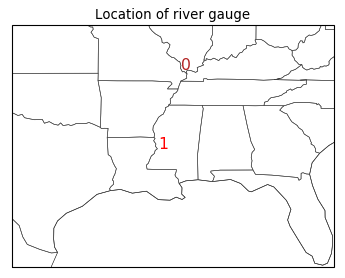

In [63]:
colorChoices = ['firebrick','red','darkorange','darkgreen','limegreen','lawngreen',
                'deepskyblue','royalblue','darkblue','darkviolet','orchid','hotpink']

#Show location of GRDC station 
fig=plt.figure(figsize=(8,4), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-100,-80,25,40])   ##Centered on US for the Mississippi
#ax.set_extent([80,130,0,35], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Mekong River 

#Add figure title, coastlines, etc. 
ax.set_title('Location of river gauge')
ax.title.set_fontsize(12)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='0.25')
#Add dot for GRDC station 
for iP in range(len(chooseBasin)):
    #ax.plot(lonGRDC_allBasin[iP],latGRDC_allBasin[iP],color=colorChoices[iP],linestyle='none',marker='*',markersize=15)
    ax.text(lonGRDC_allBasin[iP],latGRDC_allBasin[iP],str(iP),color=colorChoices[iP],fontsize=14)


In [64]:
# -- Update choice of GRDC station in full record (calcAnnAvg and errCalc) -- #

iB = 4        #Basin index 
chooseGRDC = 0 #GRDC choice on river 

calcAnnAvg[iB,:] = calcAnnAvg_allBasin[chooseGRDC,:]
errCalc[iB,:]    = errCalc_allBasin[chooseGRDC,:]


In [65]:
print(lonGRDC_allBasin[chooseGRDC],latGRDC_allBasin[chooseGRDC])


-89.464 37.2167


In [69]:
# #Mekong (basinId=25) [GRDC: 100.0833, 20.2733] --- Upstream in river 
# ilon = np.where((lon>99.5) & (lon<100.5))
# ilat = np.where((lat>20) & (lat<21))
# nearestLon[24] = lon[ilon[0][2]]
# nearestLat[24] = lat[ilat[0][2]]
# # print(lon[ilon])
# # print(lat[ilat])
# # print(globalVarCtrl[ilat[0][2],ilon[0][2],0])
# # print(nearestLon[24],nearestLat[24])
# #--[CaMa: 100.125 20.375] 


#Mississippi (basinId=5) [GRDC:  -89.464, 37.2167]
ilon = np.where((lon>-90) & (lon<-89))
ilat = np.where((lat>37) & (lat<38))
nearestLon[iB] = lon[ilon[0][2]]
nearestLat[iB] = lat[ilat[0][2]]
print(lon[ilon])
print(lat[ilat])
print(globalVarCtrl[ilat[0][:],ilon[0][2],0])
print(nearestLon[iB],nearestLat[iB])
#--[CaMa: -89.375 37.375]


[-89.875 -89.625 -89.375 -89.125]
[37.875 37.625 37.375 37.125]
[          nan 2661.47949219 2680.99682617           nan]
-89.375 37.375


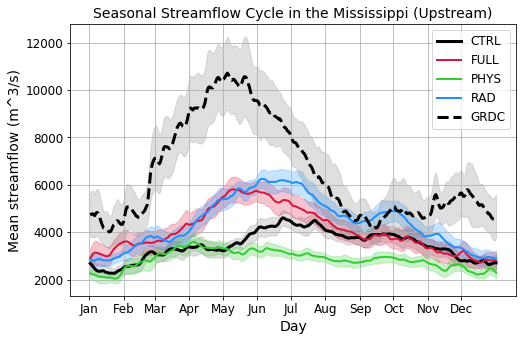

In [70]:
# --- Try making river discharge vs. GRDC at nearby gridcell 
iB = 4

indlon = np.where(lon==nearestLon[iB])
indlat = np.where(lat==nearestLat[iB])

fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and size sections --- 
plt.plot(days,np.squeeze(globalVarCtrl[indlat,indlon,:]),color ='Black',label='CTRL',linewidth=3)
plt.plot(days,np.squeeze(globalVarFull[indlat,indlon,:]),color ='Crimson',label='FULL',linewidth=2)
plt.plot(days,np.squeeze(globalVarPhys[indlat,indlon,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(days,np.squeeze(globalVarRad[indlat,indlon,:]),color='DodgerBlue',label='RAD',linewidth=2)
plt.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
plt.fill_between(days,np.squeeze(globalVarCtrl[indlat,indlon,:])-(2*np.squeeze(globalErrCtrl[indlat,indlon,:])),np.squeeze(globalVarCtrl[indlat,indlon,:])+(2*np.squeeze(globalErrCtrl[indlat,indlon,:])),alpha=0.25,color='Grey')
plt.fill_between(days,np.squeeze(globalVarFull[indlat,indlon,:])-(2*np.squeeze(globalErrFull[indlat,indlon,:])),np.squeeze(globalVarFull[indlat,indlon,:])+(2*np.squeeze(globalErrFull[indlat,indlon,:])),alpha=0.25,color='Crimson')
plt.fill_between(days,np.squeeze(globalVarPhys[indlat,indlon,:])-(2*np.squeeze(globalErrPhys[indlat,indlon,:])),np.squeeze(globalVarPhys[indlat,indlon,:])+(2*np.squeeze(globalErrPhys[indlat,indlon,:])),alpha=0.25,color='LimeGreen')
plt.fill_between(days,np.squeeze(globalVarRad[indlat,indlon,:])-(2*np.squeeze(globalErrRad[indlat,indlon,:])),np.squeeze(globalVarRad[indlat,indlon,:])+(2*np.squeeze(globalErrRad[indlat,indlon,:])),alpha=0.25,color='DodgerBlue')
plt.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')

plt.legend(fontsize=12)
plt.title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' (Upstream)',fontsize=my_fontsize)
plt.xlabel('Day',fontsize=my_fontsize)
plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
plt.grid()
plt.xticks(startMon,months)
plt.tick_params(axis='both',labelsize=12)

#Save the image 
#fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/BasinStreamflow/withGRDC_singleGridcell/'+basinNames[iB]+'Upstream_SeasonalCycle.jpg'
#fig.savefig(fileName)  #HOW TO SAVE FIGURES 



## How sensitive are these result to the choice of CaMa grid cell used for comparison? 

In [34]:
# Choose 4 points surrounding the GRDC station for upstream Mekong 

ilon = np.where((lon>99.5) & (lon<100.5))
ilat = np.where((lat>20) & (lat<21))

indlon1 = np.where(lon==lon[ilon[0][2]])   #Original point chosen for analysis 
indlat1 = np.where(lat==lat[ilat[0][2]])

indlon2 = np.where(lon==lon[ilon[0][3]])
indlat2 = np.where(lat==lat[ilat[0][3]])

indlon3 = np.where(lon==lon[ilon[0][2]])
indlat3 = np.where(lat==lat[ilat[0][1]])

indlon4 = np.where(lon==lon[ilon[0][3]])
indlat4 = np.where(lat==lat[ilat[0][2]])


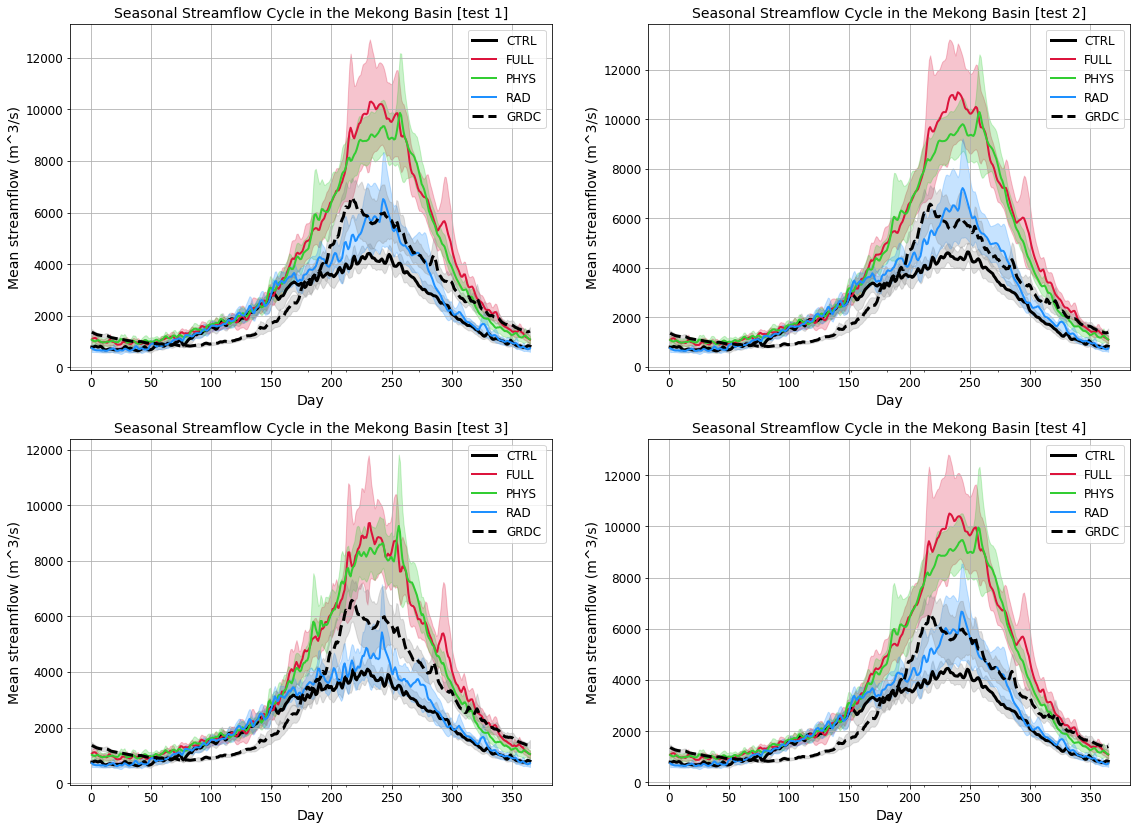

In [35]:
## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = ax_array.flatten()
fig.set_size_inches(19,14)
my_fontsize = 14

## --- TEST 1 --- 
ax1.plot(days,np.squeeze(globalVarCtrl[indlat1,indlon1,:]),color ='Black',label='CTRL',linewidth=3)
ax1.plot(days,np.squeeze(globalVarFull[indlat1,indlon1,:]),color ='Crimson',label='FULL',linewidth=2)
ax1.plot(days,np.squeeze(globalVarPhys[indlat1,indlon1,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax1.plot(days,np.squeeze(globalVarRad[indlat1,indlon1,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax1.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax1.fill_between(days,np.squeeze(globalVarCtrl[indlat1,indlon1,:])-(2*np.squeeze(globalErrCtrl[indlat1,indlon1,:])),np.squeeze(globalVarCtrl[indlat1,indlon1,:])+(2*np.squeeze(globalErrCtrl[indlat1,indlon1,:])),alpha=0.25,color='Grey')
ax1.fill_between(days,np.squeeze(globalVarFull[indlat1,indlon1,:])-(2*np.squeeze(globalErrFull[indlat1,indlon1,:])),np.squeeze(globalVarFull[indlat1,indlon1,:])+(2*np.squeeze(globalErrFull[indlat1,indlon1,:])),alpha=0.25,color='Crimson')
ax1.fill_between(days,np.squeeze(globalVarPhys[indlat1,indlon1,:])-(2*np.squeeze(globalErrPhys[indlat1,indlon1,:])),np.squeeze(globalVarPhys[indlat1,indlon1,:])+(2*np.squeeze(globalErrPhys[indlat1,indlon1,:])),alpha=0.25,color='LimeGreen')
ax1.fill_between(days,np.squeeze(globalVarRad[indlat1,indlon1,:])-(2*np.squeeze(globalErrRad[indlat1,indlon1,:])),np.squeeze(globalVarRad[indlat1,indlon1,:])+(2*np.squeeze(globalErrRad[indlat1,indlon1,:])),alpha=0.25,color='DodgerBlue')
ax1.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax1.legend(fontsize=12)
ax1.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 1]',fontsize=my_fontsize)
ax1.set_xlabel('Day',fontsize=my_fontsize)
ax1.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax1.grid()
ax1.set_xticks(startMon,months)
ax1.tick_params(axis='both',labelsize=12)

## --- TEST 2 --- 
ax2.plot(days,np.squeeze(globalVarCtrl[indlat2,indlon2,:]),color ='Black',label='CTRL',linewidth=3)
ax2.plot(days,np.squeeze(globalVarFull[indlat2,indlon2,:]),color ='Crimson',label='FULL',linewidth=2)
ax2.plot(days,np.squeeze(globalVarPhys[indlat2,indlon2,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax2.plot(days,np.squeeze(globalVarRad[indlat2,indlon2,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax2.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax2.fill_between(days,np.squeeze(globalVarCtrl[indlat2,indlon2,:])-(2*np.squeeze(globalErrCtrl[indlat2,indlon2,:])),np.squeeze(globalVarCtrl[indlat2,indlon2,:])+(2*np.squeeze(globalErrCtrl[indlat2,indlon2,:])),alpha=0.25,color='Grey')
ax2.fill_between(days,np.squeeze(globalVarFull[indlat2,indlon2,:])-(2*np.squeeze(globalErrFull[indlat2,indlon2,:])),np.squeeze(globalVarFull[indlat2,indlon2,:])+(2*np.squeeze(globalErrFull[indlat2,indlon2,:])),alpha=0.25,color='Crimson')
ax2.fill_between(days,np.squeeze(globalVarPhys[indlat2,indlon2,:])-(2*np.squeeze(globalErrPhys[indlat2,indlon2,:])),np.squeeze(globalVarPhys[indlat2,indlon2,:])+(2*np.squeeze(globalErrPhys[indlat2,indlon2,:])),alpha=0.25,color='LimeGreen')
ax2.fill_between(days,np.squeeze(globalVarRad[indlat2,indlon2,:])-(2*np.squeeze(globalErrRad[indlat2,indlon2,:])),np.squeeze(globalVarRad[indlat2,indlon2,:])+(2*np.squeeze(globalErrRad[indlat2,indlon2,:])),alpha=0.25,color='DodgerBlue')
ax2.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax2.legend(fontsize=12)
ax2.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 2]',fontsize=my_fontsize)
ax2.set_xlabel('Day',fontsize=my_fontsize)
ax2.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax2.grid()
ax2.set_xticks(startMon,months)
ax2.tick_params(axis='both',labelsize=12)

## --- TEST 3 --- 
ax3.plot(days,np.squeeze(globalVarCtrl[indlat3,indlon3,:]),color ='Black',label='CTRL',linewidth=3)
ax3.plot(days,np.squeeze(globalVarFull[indlat3,indlon3,:]),color ='Crimson',label='FULL',linewidth=2)
ax3.plot(days,np.squeeze(globalVarPhys[indlat3,indlon3,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax3.plot(days,np.squeeze(globalVarRad[indlat3,indlon3,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax3.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax3.fill_between(days,np.squeeze(globalVarCtrl[indlat3,indlon3,:])-(2*np.squeeze(globalErrCtrl[indlat3,indlon3,:])),np.squeeze(globalVarCtrl[indlat3,indlon3,:])+(2*np.squeeze(globalErrCtrl[indlat3,indlon3,:])),alpha=0.25,color='Grey')
ax3.fill_between(days,np.squeeze(globalVarFull[indlat3,indlon3,:])-(2*np.squeeze(globalErrFull[indlat3,indlon3,:])),np.squeeze(globalVarFull[indlat3,indlon3,:])+(2*np.squeeze(globalErrFull[indlat3,indlon3,:])),alpha=0.25,color='Crimson')
ax3.fill_between(days,np.squeeze(globalVarPhys[indlat3,indlon3,:])-(2*np.squeeze(globalErrPhys[indlat3,indlon3,:])),np.squeeze(globalVarPhys[indlat3,indlon3,:])+(2*np.squeeze(globalErrPhys[indlat3,indlon3,:])),alpha=0.25,color='LimeGreen')
ax3.fill_between(days,np.squeeze(globalVarRad[indlat3,indlon3,:])-(2*np.squeeze(globalErrRad[indlat3,indlon3,:])),np.squeeze(globalVarRad[indlat3,indlon3,:])+(2*np.squeeze(globalErrRad[indlat3,indlon3,:])),alpha=0.25,color='DodgerBlue')
ax3.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax3.legend(fontsize=12)
ax3.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 3]',fontsize=my_fontsize)
ax3.set_xlabel('Day',fontsize=my_fontsize)
ax3.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax3.grid()
ax3.set_xticks(startMon,months)
ax3.tick_params(axis='both',labelsize=12)

## --- TEST 4 --- 
ax4.plot(days,np.squeeze(globalVarCtrl[indlat4,indlon4,:]),color ='Black',label='CTRL',linewidth=3)
ax4.plot(days,np.squeeze(globalVarFull[indlat4,indlon4,:]),color ='Crimson',label='FULL',linewidth=2)
ax4.plot(days,np.squeeze(globalVarPhys[indlat4,indlon4,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax4.plot(days,np.squeeze(globalVarRad[indlat4,indlon4,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax4.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax4.fill_between(days,np.squeeze(globalVarCtrl[indlat4,indlon4,:])-(2*np.squeeze(globalErrCtrl[indlat4,indlon4,:])),np.squeeze(globalVarCtrl[indlat4,indlon4,:])+(2*np.squeeze(globalErrCtrl[indlat4,indlon4,:])),alpha=0.25,color='Grey')
ax4.fill_between(days,np.squeeze(globalVarFull[indlat4,indlon4,:])-(2*np.squeeze(globalErrFull[indlat4,indlon4,:])),np.squeeze(globalVarFull[indlat4,indlon4,:])+(2*np.squeeze(globalErrFull[indlat4,indlon4,:])),alpha=0.25,color='Crimson')
ax4.fill_between(days,np.squeeze(globalVarPhys[indlat4,indlon4,:])-(2*np.squeeze(globalErrPhys[indlat4,indlon4,:])),np.squeeze(globalVarPhys[indlat4,indlon4,:])+(2*np.squeeze(globalErrPhys[indlat4,indlon4,:])),alpha=0.25,color='LimeGreen')
ax4.fill_between(days,np.squeeze(globalVarRad[indlat4,indlon4,:])-(2*np.squeeze(globalErrRad[indlat4,indlon4,:])),np.squeeze(globalVarRad[indlat4,indlon4,:])+(2*np.squeeze(globalErrRad[indlat4,indlon4,:])),alpha=0.25,color='DodgerBlue')
ax4.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax4.legend(fontsize=12)
ax4.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 4]',fontsize=my_fontsize)
ax4.set_xlabel('Day',fontsize=my_fontsize)
ax4.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax4.grid()
ax4.set_xticks(startMon,months)
ax4.tick_params(axis='both',labelsize=12)


**Same test in the Mississippi**

In [76]:
# Choose 4 points surrounding the GRDC station for upstream Mississippi 

ilon = np.where((lon>-90) & (lon<-89))
ilat = np.where((lat>37) & (lat<38))
#GRDC station: -89.464, 37.2167

#print(lon[ilon])
#print(lat[ilat])
#print(globalVarCtrl[ilat[0][:],ilon[0][2],0])

indlon1 = np.where(lon==lon[ilon[0][2]])   #Original point chosen for analysis 
indlat1 = np.where(lat==lat[ilat[0][2]])

indlon2 = np.where(lon==lon[ilon[0][1]])
indlat2 = np.where(lat==lat[ilat[0][0]])

indlon3 = np.where(lon==lon[ilon[0][2]])
indlat3 = np.where(lat==lat[ilat[0][1]])

indlon4 = np.where(lon==lon[ilon[0][3]])
indlat4 = np.where(lat==lat[ilat[0][3]])



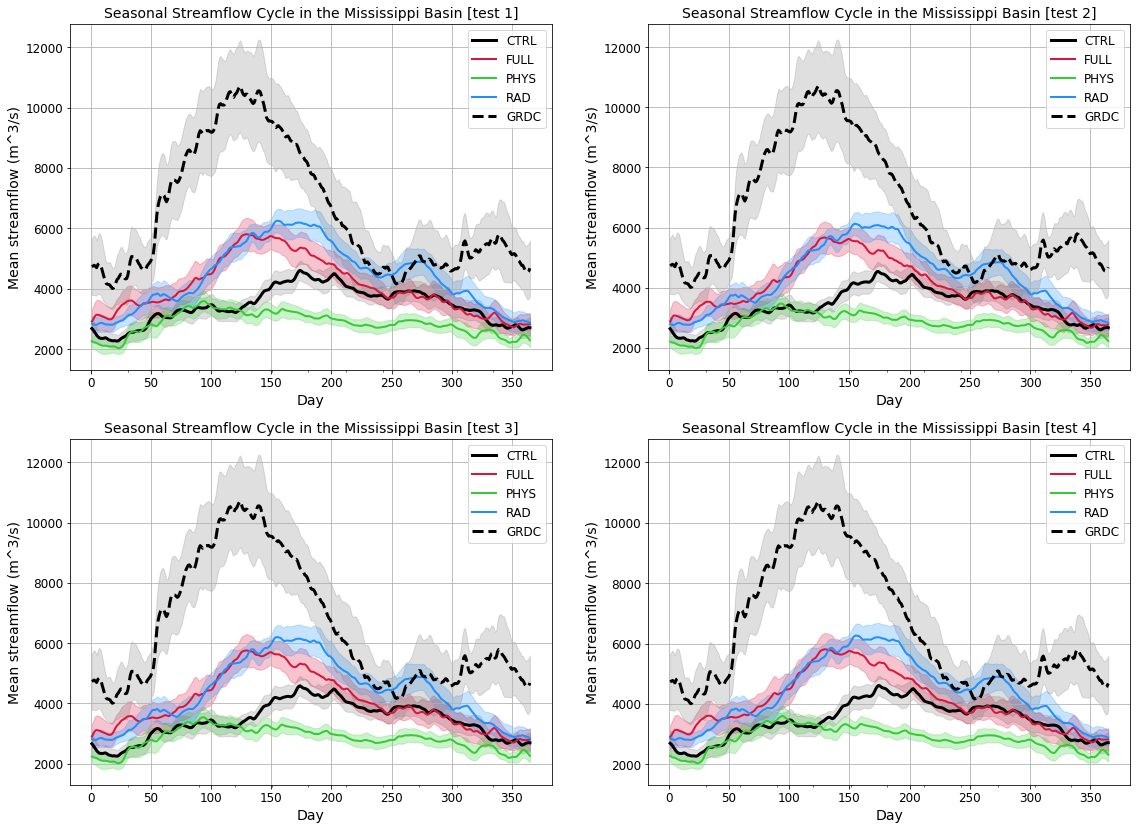

In [77]:
## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = ax_array.flatten()
fig.set_size_inches(19,14)
my_fontsize = 14
iB = 4

## --- TEST 1 --- 
ax1.plot(days,np.squeeze(globalVarCtrl[indlat1,indlon1,:]),color ='Black',label='CTRL',linewidth=3)
ax1.plot(days,np.squeeze(globalVarFull[indlat1,indlon1,:]),color ='Crimson',label='FULL',linewidth=2)
ax1.plot(days,np.squeeze(globalVarPhys[indlat1,indlon1,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax1.plot(days,np.squeeze(globalVarRad[indlat1,indlon1,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax1.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax1.fill_between(days,np.squeeze(globalVarCtrl[indlat1,indlon1,:])-(2*np.squeeze(globalErrCtrl[indlat1,indlon1,:])),np.squeeze(globalVarCtrl[indlat1,indlon1,:])+(2*np.squeeze(globalErrCtrl[indlat1,indlon1,:])),alpha=0.25,color='Grey')
ax1.fill_between(days,np.squeeze(globalVarFull[indlat1,indlon1,:])-(2*np.squeeze(globalErrFull[indlat1,indlon1,:])),np.squeeze(globalVarFull[indlat1,indlon1,:])+(2*np.squeeze(globalErrFull[indlat1,indlon1,:])),alpha=0.25,color='Crimson')
ax1.fill_between(days,np.squeeze(globalVarPhys[indlat1,indlon1,:])-(2*np.squeeze(globalErrPhys[indlat1,indlon1,:])),np.squeeze(globalVarPhys[indlat1,indlon1,:])+(2*np.squeeze(globalErrPhys[indlat1,indlon1,:])),alpha=0.25,color='LimeGreen')
ax1.fill_between(days,np.squeeze(globalVarRad[indlat1,indlon1,:])-(2*np.squeeze(globalErrRad[indlat1,indlon1,:])),np.squeeze(globalVarRad[indlat1,indlon1,:])+(2*np.squeeze(globalErrRad[indlat1,indlon1,:])),alpha=0.25,color='DodgerBlue')
ax1.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax1.legend(fontsize=12)
ax1.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 1]',fontsize=my_fontsize)
ax1.set_xlabel('Day',fontsize=my_fontsize)
ax1.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax1.grid()
ax1.set_xticks(startMon,months)
ax1.tick_params(axis='both',labelsize=12)

## --- TEST 2 --- 
ax2.plot(days,np.squeeze(globalVarCtrl[indlat2,indlon2,:]),color ='Black',label='CTRL',linewidth=3)
ax2.plot(days,np.squeeze(globalVarFull[indlat2,indlon2,:]),color ='Crimson',label='FULL',linewidth=2)
ax2.plot(days,np.squeeze(globalVarPhys[indlat2,indlon2,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax2.plot(days,np.squeeze(globalVarRad[indlat2,indlon2,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax2.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax2.fill_between(days,np.squeeze(globalVarCtrl[indlat2,indlon2,:])-(2*np.squeeze(globalErrCtrl[indlat2,indlon2,:])),np.squeeze(globalVarCtrl[indlat2,indlon2,:])+(2*np.squeeze(globalErrCtrl[indlat2,indlon2,:])),alpha=0.25,color='Grey')
ax2.fill_between(days,np.squeeze(globalVarFull[indlat2,indlon2,:])-(2*np.squeeze(globalErrFull[indlat2,indlon2,:])),np.squeeze(globalVarFull[indlat2,indlon2,:])+(2*np.squeeze(globalErrFull[indlat2,indlon2,:])),alpha=0.25,color='Crimson')
ax2.fill_between(days,np.squeeze(globalVarPhys[indlat2,indlon2,:])-(2*np.squeeze(globalErrPhys[indlat2,indlon2,:])),np.squeeze(globalVarPhys[indlat2,indlon2,:])+(2*np.squeeze(globalErrPhys[indlat2,indlon2,:])),alpha=0.25,color='LimeGreen')
ax2.fill_between(days,np.squeeze(globalVarRad[indlat2,indlon2,:])-(2*np.squeeze(globalErrRad[indlat2,indlon2,:])),np.squeeze(globalVarRad[indlat2,indlon2,:])+(2*np.squeeze(globalErrRad[indlat2,indlon2,:])),alpha=0.25,color='DodgerBlue')
ax2.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax2.legend(fontsize=12)
ax2.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 2]',fontsize=my_fontsize)
ax2.set_xlabel('Day',fontsize=my_fontsize)
ax2.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax2.grid()
ax2.set_xticks(startMon,months)
ax2.tick_params(axis='both',labelsize=12)

## --- TEST 3 --- 
ax3.plot(days,np.squeeze(globalVarCtrl[indlat3,indlon3,:]),color ='Black',label='CTRL',linewidth=3)
ax3.plot(days,np.squeeze(globalVarFull[indlat3,indlon3,:]),color ='Crimson',label='FULL',linewidth=2)
ax3.plot(days,np.squeeze(globalVarPhys[indlat3,indlon3,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax3.plot(days,np.squeeze(globalVarRad[indlat3,indlon3,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax3.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax3.fill_between(days,np.squeeze(globalVarCtrl[indlat3,indlon3,:])-(2*np.squeeze(globalErrCtrl[indlat3,indlon3,:])),np.squeeze(globalVarCtrl[indlat3,indlon3,:])+(2*np.squeeze(globalErrCtrl[indlat3,indlon3,:])),alpha=0.25,color='Grey')
ax3.fill_between(days,np.squeeze(globalVarFull[indlat3,indlon3,:])-(2*np.squeeze(globalErrFull[indlat3,indlon3,:])),np.squeeze(globalVarFull[indlat3,indlon3,:])+(2*np.squeeze(globalErrFull[indlat3,indlon3,:])),alpha=0.25,color='Crimson')
ax3.fill_between(days,np.squeeze(globalVarPhys[indlat3,indlon3,:])-(2*np.squeeze(globalErrPhys[indlat3,indlon3,:])),np.squeeze(globalVarPhys[indlat3,indlon3,:])+(2*np.squeeze(globalErrPhys[indlat3,indlon3,:])),alpha=0.25,color='LimeGreen')
ax3.fill_between(days,np.squeeze(globalVarRad[indlat3,indlon3,:])-(2*np.squeeze(globalErrRad[indlat3,indlon3,:])),np.squeeze(globalVarRad[indlat3,indlon3,:])+(2*np.squeeze(globalErrRad[indlat3,indlon3,:])),alpha=0.25,color='DodgerBlue')
ax3.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax3.legend(fontsize=12)
ax3.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 3]',fontsize=my_fontsize)
ax3.set_xlabel('Day',fontsize=my_fontsize)
ax3.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax3.grid()
ax3.set_xticks(startMon,months)
ax3.tick_params(axis='both',labelsize=12)

## --- TEST 4 --- 
ax4.plot(days,np.squeeze(globalVarCtrl[indlat4,indlon4,:]),color ='Black',label='CTRL',linewidth=3)
ax4.plot(days,np.squeeze(globalVarFull[indlat4,indlon4,:]),color ='Crimson',label='FULL',linewidth=2)
ax4.plot(days,np.squeeze(globalVarPhys[indlat4,indlon4,:]),color = 'LimeGreen',label='PHYS',linewidth=2)
ax4.plot(days,np.squeeze(globalVarRad[indlat4,indlon4,:]),color='DodgerBlue',label='RAD',linewidth=2)
ax4.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
ax4.fill_between(days,np.squeeze(globalVarCtrl[indlat4,indlon4,:])-(2*np.squeeze(globalErrCtrl[indlat4,indlon4,:])),np.squeeze(globalVarCtrl[indlat4,indlon4,:])+(2*np.squeeze(globalErrCtrl[indlat4,indlon4,:])),alpha=0.25,color='Grey')
ax4.fill_between(days,np.squeeze(globalVarFull[indlat4,indlon4,:])-(2*np.squeeze(globalErrFull[indlat4,indlon4,:])),np.squeeze(globalVarFull[indlat4,indlon4,:])+(2*np.squeeze(globalErrFull[indlat4,indlon4,:])),alpha=0.25,color='Crimson')
ax4.fill_between(days,np.squeeze(globalVarPhys[indlat4,indlon4,:])-(2*np.squeeze(globalErrPhys[indlat4,indlon4,:])),np.squeeze(globalVarPhys[indlat4,indlon4,:])+(2*np.squeeze(globalErrPhys[indlat4,indlon4,:])),alpha=0.25,color='LimeGreen')
ax4.fill_between(days,np.squeeze(globalVarRad[indlat4,indlon4,:])-(2*np.squeeze(globalErrRad[indlat4,indlon4,:])),np.squeeze(globalVarRad[indlat4,indlon4,:])+(2*np.squeeze(globalErrRad[indlat4,indlon4,:])),alpha=0.25,color='DodgerBlue')
ax4.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')
#Other options 
ax4.legend(fontsize=12)
ax4.set_title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' Basin [test 4]',fontsize=my_fontsize)
ax4.set_xlabel('Day',fontsize=my_fontsize)
ax4.set_ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
ax4.grid()
ax4.set_xticks(startMon,months)
ax4.tick_params(axis='both',labelsize=12)



## Could we average together all model gridcells within some distance of GRDC station? 

In [10]:
#Mekong (basinId=25) [GRDC: 100.0833, 20.2733] --- Upstream in river 
chooseGRDC = 27-1

grdcLon = lonGRDC_allBasin[chooseGRDC]
grdcLat = latGRDC_allBasin[chooseGRDC]
print(grdcLon,grdcLat)

ilon = np.where((lon>(grdcLon-0.25)) & (lon<(grdcLon+0.25)))
ilat = np.where((lat>(grdcLat-0.25)) & (lat<(grdcLat+0.25)))

#Isolate region in each experiment and average over that domain 
ctrl_region    = globalVarCtrl[ilat[0][:],:,:]
ctrl_region    = ctrl_region[:,ilon[0][:],:]
avgCtrl_region = np.nanmean(np.nanmean(ctrl_region,axis=0),axis=0)

full_region    = globalVarFull[ilat[0][:],:,:]
full_region    = full_region[:,ilon[0][:],:]
avgFull_region = np.nanmean(np.nanmean(full_region,axis=0),axis=0)

phys_region    = globalVarPhys[ilat[0][:],:,:]
phys_region    = phys_region[:,ilon[0][:],:]
avgPhys_region = np.nanmean(np.nanmean(phys_region,axis=0),axis=0)

rad_region    = globalVarRad[ilat[0][:],:,:]
rad_region    = rad_region[:,ilon[0][:],:]
avgRad_region = np.nanmean(np.nanmean(rad_region,axis=0),axis=0)

#Take same averaging approach for standard error (is this the right way to go??)
ctrl_err      = globalErrCtrl[ilat[0][:],:,:]
ctrl_err      = ctrl_err[:,ilon[0][:],:]
errCtrl_region = np.nanmean(np.nanmean(ctrl_err,axis=0),axis=0)

full_err      = globalErrFull[ilat[0][:],:,:]
full_err      = full_err[:,ilon[0][:],:]
errFull_region = np.nanmean(np.nanmean(full_err,axis=0),axis=0)

phys_err      = globalErrPhys[ilat[0][:],:,:]
phys_err      = phys_err[:,ilon[0][:],:]
errPhys_region = np.nanmean(np.nanmean(phys_err,axis=0),axis=0)

rad_err       = globalErrRad[ilat[0][:],:,:]
rad_err       = rad_err[:,ilon[0][:],:]
errRad_region = np.nanmean(np.nanmean(rad_err,axis=0),axis=0)


NameError: name 'lonGRDC_allBasin' is not defined

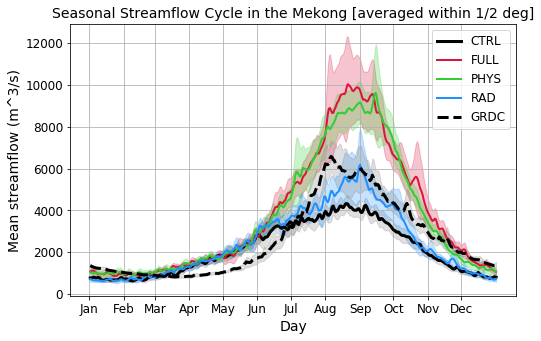

In [60]:
# --- Try making river discharge vs. GRDC at nearby gridcell 
iB = 24

fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and size sections --- 
plt.plot(days,avgCtrl_region,color ='Black',label='CTRL',linewidth=3)
plt.plot(days,avgFull_region,color ='Crimson',label='FULL',linewidth=2)
plt.plot(days,avgPhys_region,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(days,avgRad_region,color='DodgerBlue',label='RAD',linewidth=2)
plt.plot(days,calcAnnAvg[iB,:],linestyle='dashed',color ='Black',label='GRDC',linewidth=3)
#Add error "bars"
plt.fill_between(days,avgCtrl_region-(2*errCtrl_region),avgCtrl_region+(2*errCtrl_region),alpha=0.25,color='Grey')
plt.fill_between(days,avgFull_region-(2*errFull_region),avgFull_region+(2*errFull_region),alpha=0.25,color='Crimson')
plt.fill_between(days,avgPhys_region-(2*errPhys_region),avgPhys_region+(2*errPhys_region),alpha=0.25,color='LimeGreen')
plt.fill_between(days,avgRad_region-(2*errRad_region),avgRad_region+(2*errRad_region),alpha=0.25,color='DodgerBlue')
plt.fill_between(days,calcAnnAvg[iB,:]-(2*errCalc[iB,:]),calcAnnAvg[iB,:]+(2*errCalc[iB,:]),alpha=0.25,color='Grey')

plt.legend(fontsize=12)
plt.title('Seasonal Streamflow Cycle in the '+basinNames[iB]+ ' [averaged within 0.25 deg]',fontsize=my_fontsize)
plt.xlabel('Day',fontsize=my_fontsize)
plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
plt.grid()
plt.xticks(startMon,months)
plt.tick_params(axis='both',labelsize=12)



## Scratchwork 

In [ ]:

#Method based on using thirty years towards end of data - 
# ---- DOESN'T WORK ------

daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

for iBasin in range(len(grdcID)): 
    if np.isnan(grdcID[iBasin])==False:
        
        #Find last year of full data 
        endYr = np.nanmax(year[iBasin,:])
        if np.shape(np.where(year[iBasin,:]==np.nanmax(year[iBasin,:])))!=365:
            endYr = np.nanmax(year[iBasin,:])-1
            #print('For basin ',iBasin,', endYr set to ', endYr, 'with ',np.shape(np.where(year[iBasin,:]==np.nanmax(year[iBasin,:])-1)),'days')
        
        #Define first year of data as 30 years prior to last year 
        startYr = endYr-29 
        
        #Find indices of those years 
        iEnd   = np.nanmax(np.where(year[iBasin,:]==endYr))
        iStart = np.nanmin(np.where(year[iBasin,:]==startYr))
        print('Basin #',iBasin,'... StartInd:',iStart,'...EndInd:',iEnd)
        
#         origBasin = orig[iBasin,iStart:iEnd]
#         calcBasin = calc[iBasin,iStart:iEnd]
#         print(np.shape(origBasin))
        
        #Make annual average cycles 
        #for iYr in range(len(30)): 
            

